<a href="https://colab.research.google.com/github/fsona/ITA_Vaccine_administration/blob/main/Vaccination_ITA_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Italy Covid 19 vaccination data analysis and visualization

**Author**: Fabio Sona<br>
**Date**: 16 April 2021<br>
**Content**<br>
Data visualization and analysis of Italy Covid 19 vaccination progress based on opendata repository managed, on github, by "**Italian Government**" 

---


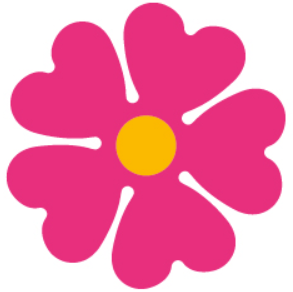

## Libraries Import 

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from matplotlib import gridspec
import seaborn as sns
import datetime
from datetime import date
import numpy as np
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import scipy.special as sps 
import warnings 

ita_pop=60244639 #'Italian population'
# ita_pop=59641488 #'Italian population'

## Data upload and cleaning

In [41]:
#%%
# Read region based data  from Italian Government repository 
dfVana=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/anagrafica-vaccini-summary-latest.csv")
dfVdel=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/consegne-vaccini-latest.csv",index_col=3, parse_dates=True)
dfVadm_loc=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/punti-somministrazione-latest.csv")
dfVloc_type=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/punti-somministrazione-tipologia.csv")
dfVadm=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv",index_col=0, parse_dates=True)
dfVadm_sum=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-summary-latest.csv",parse_dates=True)
dfVsum=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/vaccini-summary-latest.csv")

In [42]:
dfVdel[dfVdel['fornitore']=='Janssen']

#dfVadm[dfVadm['fornitore']=='Janssen']

,area,fornitore,numero_dosi,codice_NUTS1,codice_NUTS2,codice_regione_ISTAT,nome_area
data_consegna,,,,,,,
2021-03-01,ABR,Janssen,0,ITF,ITF1,13,Abruzzo
2021-03-01,BAS,Janssen,0,ITF,ITF5,17,Basilicata
2021-03-01,CAL,Janssen,0,ITF,ITF6,18,Calabria
2021-03-01,CAM,Janssen,0,ITF,ITF3,15,Campania
2021-03-01,EMR,Janssen,0,ITH,ITH5,8,Emilia-Romagna
2021-03-01,FVG,Janssen,0,ITH,ITH4,6,Friuli-Venezia Giulia
2021-03-01,LAZ,Janssen,0,ITI,ITI4,12,Lazio
2021-03-01,LIG,Janssen,0,ITC,ITC3,7,Liguria
2021-03-01,LOM,Janssen,0,ITC,ITC4,3,Lombardia


## Vaccine administration, delivery and utilisation progress

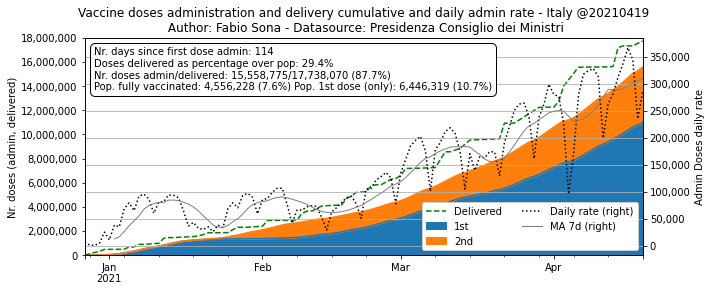

In [64]:
#
#PLOT VACCINE DOSE ADMINISTRATION VS DELIVERED CUMLATIVE PROGRESS AND DAILY RATE NATIONWIDE
#
#Prepare administered dataframe
dfAdm=dfVadm.copy()
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm['Week_Number'] = dfAdm.index.weekofyear
dfAdm['Year'] = dfAdm.index.year
dfAdm=dfAdm[['prima_dose','seconda_dose']]
dfAdm=dfAdm.groupby(['data_somministrazione']).sum() 
dfDailyAdm=dfAdm['prima_dose']+dfAdm['seconda_dose'] #copy daily administration 
dfAdm=dfAdm.cumsum()
dfAdm=dfAdm.rename(columns={"prima_dose": "1st", "seconda_dose": "2nd"})

#Prepare delivered dataframe
dfDel=dfVdel.copy()
dfDel=dfDel.groupby(['data_consegna']).sum() 
dfDel=dfDel.cumsum()
dfDel=dfDel.fillna(method='ffill')
max_y=dfDel.iloc[-1].numero_dosi #scaling factor for y axis
max_y=(int(max_y/1e6)+1)*1e6
#Prepare dose utilisation dataframe
dfTD=dfVdel.groupby(['fornitore']).sum()
dfTA=dfVadm.groupby(['fornitore']).sum()
dfTA['tot_admin']=dfTA['prima_dose']+dfTA['seconda_dose']
dfU=pd.concat([dfTA,dfTD],axis=1)

dfU['ratio']=dfU['tot_admin']/dfU['numero_dosi']
dfU['stock']=dfU['numero_dosi']-dfU['tot_admin']
util=dfU['tot_admin'].sum()/dfU['numero_dosi'].sum()
util='{:.1%}'.format(util)
ut_str=''
st_str=''
for s in dfU.index:
  tu='{:.1%}'.format(dfU.loc[s].ratio)  
  st='{:,.0f}'.format(dfU.loc[s].stock)
  ut_str=ut_str+s+' '+ tu+', '
  st_str=st_str+s+' '+ st+', '
max_del='{:,.0f}'.format(dfDel.iloc[-1].numero_dosi)

#Get last date of relevant data 
today=dfVadm.index.max()  
d=today.strftime("%Y%m%d")

MA=7 #moving average param
length=dfAdm.shape[0]

#Calc parameters to display in the box
totadmin=(dfAdm.iloc[-1]['1st']+dfAdm.iloc[-1]['2nd'])
prc_atone=int(totadmin/ita_pop*100*10)/10
full_vacc=dfAdm.iloc[-1]['2nd']
strfull_vacc='{:,.0f}'.format(full_vacc)

prc_full=dfAdm.iloc[-1]['2nd']/ita_pop
str_prc_full='{:.1%}'.format(prc_full)
oned_vacc=totadmin-2*full_vacc
stroned_vacc='{:,.0f}'.format(oned_vacc)
prc_oned=oned_vacc/ita_pop
strprc_oned='{:.1%}'.format(prc_oned)
max_del='{:,.0f}'.format(dfDel.iloc[-1].numero_dosi)
max_adm='{:,.0f}'.format(totadmin)
del_pop=dfDel.iloc[-1].numero_dosi/ita_pop
strdel_pop='{:.1%}'.format(del_pop)
date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format

#Plot vaccination progresses
fig, ax =plt.subplots(figsize=(10,4))
dfAdm.plot.area(ax=ax)
dfDel['numero_dosi'].plot(kind='line', linestyle="--",color='green',label='Delivered',ax=ax)
ax2=ax.twinx()
dfDailyAdm.plot(kind='line', linestyle=":",color='black',label='Daily rate (right)',ax=ax2)
dfDailyAdm.rolling(window=MA).mean().plot(kind='line',linestyle="-",lw=1,color='grey',label='MA 7d (right)',ax=ax2)
ax.set_xlabel('')
ax.set_ylabel('Nr. doses (admin, delivered)')
ax2.set_ylabel('Admin Doses daily rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylim([0,max_y]) 
ax.grid(False)
ax2.yaxis.grid(True)

str_cnt = 'Nr. days since first dose admin: '+str(length)+\
  '\nDoses delivered as percentage over pop: '+strdel_pop+\
  '\nNr. doses admin/delivered: ' + max_adm +'/'+max_del +' ('+util+')' +\
  '\nPop. fully vaccinated: '+str(strfull_vacc)+' ('+str_prc_full+')'+\
  ' Pop. 1st dose (only): '+str(stroned_vacc)+' ('+strprc_oned+')'
at = AnchoredText(str_cnt, prop=dict(size=10,color='black'), frameon=True,loc='upper left')                  
at.patch.set_boxstyle("round,pad=0,rounding_size=0.5")
ax2.add_artist(at)
ax.get_legend().remove()
# ax.legend(facecolor='white', framealpha=1)
# ax2.legend(loc='lower right',facecolor='white', framealpha=1)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="lower right",fontsize=10,facecolor='white', framealpha=1,ncol=2)


plt.title('Vaccine doses administration and delivery cumulative and daily admin rate - Italy @'+d+
          '\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',size=12)
plt.savefig('V'+d+'_ItalyDosesPhaseProgress.png',dpi=600)
plt.show()

In [44]:
dfVadm.head()

,fornitore,area,fascia_anagrafica,sesso_maschile,sesso_femminile,categoria_operatori_sanitari_sociosanitari,categoria_personale_non_sanitario,categoria_ospiti_rsa,categoria_60_69,categoria_70_79,categoria_over80,categoria_forze_armate,categoria_personale_scolastico,categoria_soggetti_fragili,categoria_altro,categoria_altro.1,prima_dose,seconda_dose,codice_NUTS1,codice_NUTS2,codice_regione_ISTAT,nome_area
data_somministrazione,,,,,,,,,,,,,,,,,,,,,,
2020-12-27,Pfizer/BioNTech,ABR,20-29,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,ABR,30-39,1,3,4,0,0,0,0,0,0,0,0,0,0,4,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,ABR,40-49,1,6,7,0,0,0,0,0,0,0,0,0,0,7,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,ABR,50-59,4,5,9,0,0,0,0,0,0,0,0,0,0,9,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,ABR,60-69,10,4,13,1,0,0,0,0,0,0,0,0,0,14,0,ITF,ITF1,13,Abruzzo


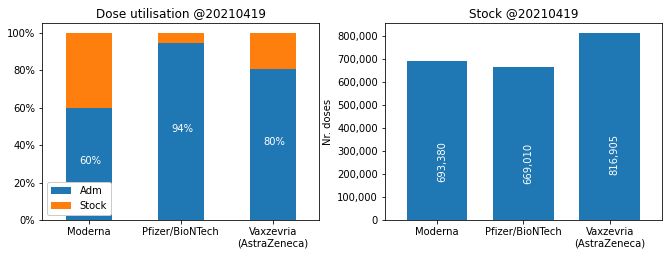

In [45]:
#PLOT VACCINE DOSES UTILISATION  BY SUPPLIER and STOCK Value

fig, axes =plt.subplots(nrows=1,ncols=2,figsize=(10,4))

fig.tight_layout(pad=3.5)

dfAdm=dfVadm.copy()
dfAdm['tot_admin']=dfAdm['prima_dose']+dfAdm['seconda_dose']
suppliers=dfAdm['fornitore'].unique()

dfDel=dfVdel.copy()
dfAdm=dfAdm.groupby(['fornitore'])['tot_admin'].sum()
dfDel=dfDel.groupby(['fornitore'])['numero_dosi'].sum()

df = pd.DataFrame({'Adm': dfAdm,'Del':dfDel})#, 'idx_col':dfDel.index})
df['Stock']=df['Del']-df['Adm']
df=df.drop(columns=['Del'])

norm_df = df.div(df.sum(axis=1), axis=0)
norm_df=norm_df.dropna()
#Plot Stock Utilisation
norm_df.plot(kind='bar',stacked=True,legend=False,ax=axes[0])
axes[0].yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
axes[0].legend(facecolor='white', framealpha=1,loc='lower left')
axes[0].set_xlabel('')
axes[0].set_xticklabels([label.replace(' ', '\n') for label in norm_df.index.values])
axes[0].xaxis.set_tick_params(rotation=0)
axes[0].set_title('Dose utilisation @'+d)
[axes[0].text(i-0.1,v/2, f'{v:,.0%}',fontsize=10,color='white',rotation='horizontal') for i, v in enumerate(norm_df['Adm'])]
# axes[0].grid(False)
# axes[0].yaxis.grid(True)
#Plot Stock Values

st=df['Stock']
st=st.dropna()
st.plot(kind='bar',legend=False,ax=axes[1],width=0.7)

axes[1].set_xlabel('')
axes[1].set_xticklabels([label.replace(' ', '\n') for label in st.index.values])

axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axes[1].xaxis.set_tick_params(rotation=0)
axes[1].set_ylabel('Nr. doses')
axes[1].set_title('Stock @'+d)
[axes[1].text(i,v/4, f'{v:,.0f}',fontsize=10,color='white',rotation='vertical') for i, v in enumerate(st)]
plt.savefig('V'+d+'_ItalyDosesUtilStock.png',dpi=600)

plt.show()


In [46]:
st.index.values

array(['Moderna', 'Pfizer/BioNTech', 'Vaxzevria (AstraZeneca)'],
      dtype=object)

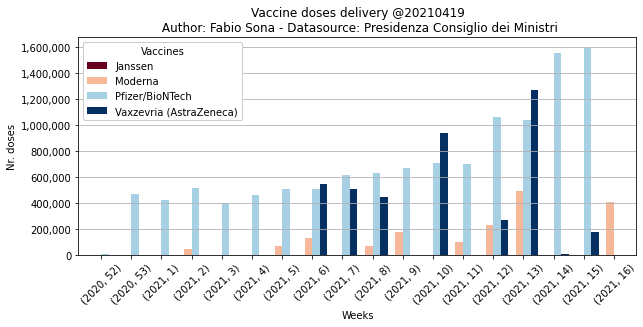

In [143]:
#
#PLOT VACCINE DOSE DELIVERY  PROGRESS PER SUPPLIER
#
dfDel=dfVdel.copy()
dfDel['Week_number'] = dfDel.index.isocalendar().week
dfDel['Year'] = dfDel.index.isocalendar().year
dfDel=pd.pivot_table(dfDel, values = 'numero_dosi',aggfunc=np.sum, index=[dfDel['Year'],dfDel['Week_number']],columns = 'fornitore')


today=dfVdel.index[-1]  
d1=today.strftime("%Y%m%d")

fig, ax =plt.subplots(figsize=(10,4))

dfDel.plot(kind='bar',xlabel='Weeks',ylabel='Nr. doses',legend=True,width=1,ax=ax,colormap='RdBu')

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticklabels(dfDel.index,fontsize=10,rotation=45)

ax.grid(False)
ax.yaxis.grid(True)
legend = plt.legend(title="Vaccines",loc="upper left",facecolor='white', framealpha=1)
# ax.legend(facecolor='white', framealpha=1)
plt.title('Vaccine doses delivery @'+d1+
          '\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',size=12) 
plt.savefig('V'+d1+'_ItalyDosesDeliveryProgress.png',dpi=600)
plt.show()

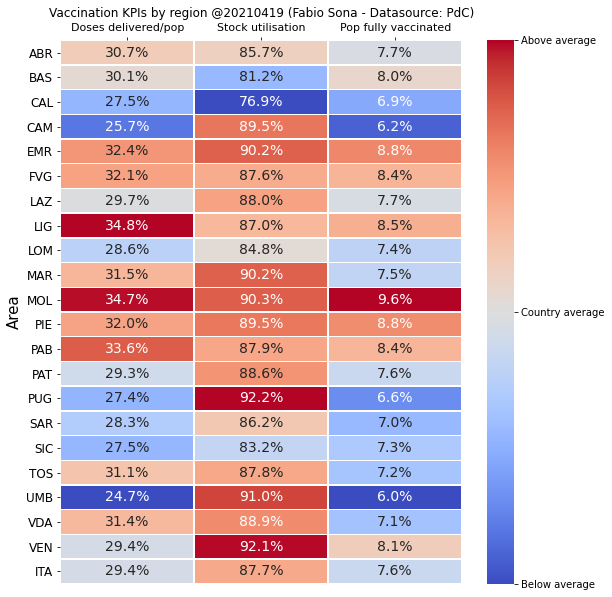

In [48]:
population = {'geo': ['Lombardia', 'Lazio','Campania','Sicilia','Veneto','Emilia-Romagna','Piemonte','Puglia','Toscana','Calabria','Sardegna','Liguria','Marche','Abruzzo','Friuli-Venezia Giulia','Provincia Autonoma Trento','Provincia Autonoma Bolzano / Bozen','Umbria','Basilicata','Molise',"Valle d'Aosta / Vallée d'Aoste"],
        'ab': [10103969,5865544,5785861,4968410,4907704,4467118,4341375,4008296,3722729,1924701,1630474,1543127,1518400,1305770,1211357,542739,532080,1074819,556934,302265,125501],
        'geoid': ['LOM', 'LAZ','CAM','SIC','VEN','EMR','PIE','PUG','TOS','CAL','SAR','LIG','MAR','ABR','FVG','PAT','PAB','UMB','BAS','MOL','VDA']
        }


#Preparing population dataframe
dfPop = pd.DataFrame (population, columns = ['geo','ab','geoid'])
dfPop=dfPop.sort_values(by=['geo'],ascending=True)
dfPop.set_index("geo", inplace=True)

# Calc three main paramaters per region
dfTab=dfVadm.groupby(['nome_area'])['prima_dose','seconda_dose'].sum()
dfTab['tot_adm']=dfTab['prima_dose']+dfTab['seconda_dose']
dfTab=dfTab.sort_values(by=['nome_area'],ascending=True)
dfTab['tot_del']=dfVdel.groupby(['nome_area'])['numero_dosi'].sum()
dfTab['pop']=dfPop['ab']
dfTab['Area']=dfPop['geoid']
dfTab['del_pop']=dfTab['tot_del']/dfTab['pop']
dfTab['adm_del']=dfTab['tot_adm']/dfTab['tot_del']
dfTab['vacc_pop']=dfTab['seconda_dose']/dfTab['pop']

# Calc total parameters
del_pop_ita=dfTab['tot_del'].sum()/ita_pop
adm_del_ita=dfTab['tot_adm'].sum()/dfTab['tot_del'].sum()
# vacc_pop_ita=dfTab['seconda_dose'].sum()/dfTab['pop'].sum()
vacc_pop_ita=dfTab['seconda_dose'].sum()/ita_pop
# Create summary table with totals and format
pd.options.display.float_format = '{:.1%}'.format

dfSum=dfTab[['del_pop','adm_del','vacc_pop','Area']]
dfSum = dfSum.append(pd.DataFrame([[del_pop_ita,adm_del_ita,vacc_pop_ita,'ITA']],index=['Italia'],columns=dfSum.columns),ignore_index=False)
dfSum = dfSum[['Area', 'del_pop', 'adm_del', 'vacc_pop']]

# Change indexing
dfSum=dfSum.reset_index(drop=True)
dfSum=dfSum.set_index('Area')

# Prepare mormalized by column dataframe
scaled_df = (dfSum - dfSum.min(axis=0))/(dfSum.max(axis=0) - dfSum.min(axis=0))

# Plot
fig, ax = plt.subplots(figsize=(9,10))
# Rename xlabels
xlabels=['Doses delivered/pop','Stock utilisation','Pop fully vaccinated']

ax=sns.heatmap(scaled_df, annot=dfSum,linewidths=.5,fmt='.1%', cmap="coolwarm",cbar=True,annot_kws={"size":14}) #cmap="Oranges",

plt.title('Vaccination KPIs by region @'+d+
          ' (Fabio Sona - Datasource: PdC)',size=12)

ax.set_xticklabels(xlabels)
ax.xaxis.set_ticks_position('top')
# Setting colormap labels
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Below average', 'Country average', 'Above average'])


plt.xticks(rotation=0,fontsize=11)
plt.ylabel('Area', fontsize = 15) # x-axis label with fontsize 15
plt.yticks(rotation=0,fontsize=12)
plt.savefig('V'+d+'_RegionalVaccinationKPI.png',dpi=600)
plt.show()
pd.reset_option('display')




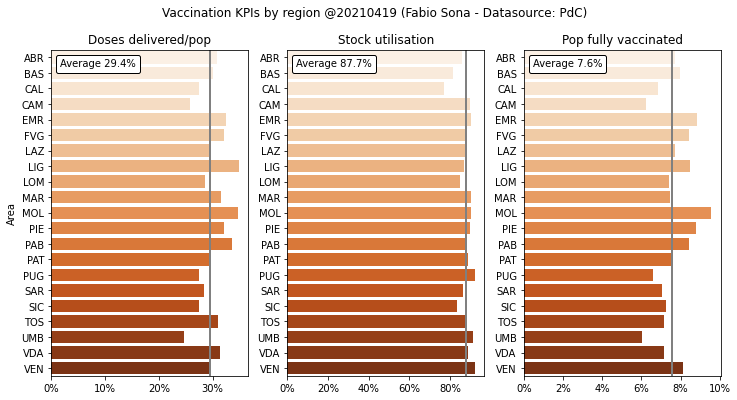

In [49]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,6),sharey=False)
# sns.color_palette("YlOrBr", as_cmap=True)
sns.barplot(x=dfSum['del_pop'][:-1],y=dfSum.index[:-1],data=dfSum,palette='Oranges',ax=axes[0])


axes[0].axvline(x=dfSum['del_pop'][-1], color='grey',lw=2, linestyle='-')
# axes[0].set_ylabel('')
axes[0].set_xlabel('')    
axes[0].set_title('Doses delivered/pop')
axes[0].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
at = AnchoredText('Average ' + '{:.1%}'.format(dfSum['del_pop'][-1]),
                  prop=dict(size=10,color='black'), frameon=True,loc='upper left')
at.patch.set_boxstyle("round,pad=0,rounding_size=0.2")
axes[0].add_artist(at)



sns.barplot(x=dfSum['adm_del'][:-1],y=dfSum.index[:-1],data=dfSum,palette='Oranges',ax=axes[1])
axes[1].axvline(x=dfSum['adm_del'][-1], color='grey',lw=2, linestyle='-')
axes[1].set_ylabel('')    
axes[1].set_xlabel('')    
axes[1].set_title('Stock utilisation')
axes[1].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
at = AnchoredText('Average ' + '{:.1%}'.format(dfSum['adm_del'][-1]),
                  prop=dict(size=10,color='black'), frameon=True,loc='upper left')
at.patch.set_boxstyle("round,pad=0,rounding_size=0.2")
axes[1].add_artist(at)

sns.barplot(x=dfSum['vacc_pop'][:-1],y=dfSum.index[:-1],data=dfSum,palette='Oranges',ax=axes[2])
# axes[2].axvline(x=dfSum['vacc_pop'][-1], color='grey',lw=2, linestyle='-')
axes[2].axvline(x=prc_full, color='grey',lw=2, linestyle='-')
axes[2].set_ylabel('')
axes[2].set_xlabel('')    
axes[2].set_title('Pop fully vaccinated')
axes[2].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
at = AnchoredText('Average ' + '{:.1%}'.format(dfSum['vacc_pop'][-1]),
                  prop=dict(size=10,color='black'), frameon=True,loc='upper left')
at.patch.set_boxstyle("round,pad=0,rounding_size=0.2")
axes[2].add_artist(at)

plt.suptitle('Vaccination KPIs by region @'+d+
          ' (Fabio Sona - Datasource: PdC)',size=12)
plt.savefig('V'+d+'_RegionalVaccinationKPI_2.png',dpi=600)
plt.show()


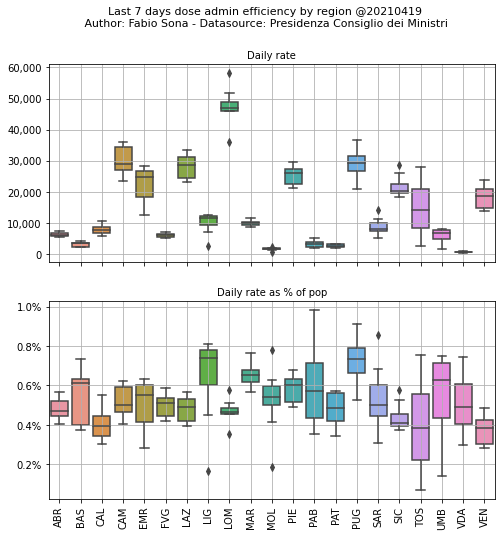

In [72]:
#Speed statistics Last "LAG"" days

population = {'geo': ['Italy','Lombardia', 'Lazio','Campania','Sicilia','Veneto','Emilia-Romagna','Piemonte','Puglia','Toscana','Calabria','Sardegna','Liguria','Marche','Abruzzo','Friuli-Venezia Giulia','Provincia Autonoma Trento','Provincia Autonoma Bolzano / Bozen','Umbria','Basilicata','Molise',"Valle d'Aosta / Vallée d'Aoste"],
        'ab': [60244639,10103969,5865544,5785861,4968410,4907704,4467118,4341375,4008296,3722729,1924701,1630474,1543127,1518400,1305770,1211357,542739,532080,1074819,556934,302265,125501],
        'geoid': ['ITA','LOM', 'LAZ','CAM','SIC','VEN','EMR','PIE','PUG','TOS','CAL','SAR','LIG','MAR','ABR','FVG','PAT','PAB','UMB','BAS','MOL','VDA']
        }


today=dfVadm.last_valid_index()
d=today.strftime("%Y%m%d")
lag=7

dfAb = pd.DataFrame (population, columns = ['geo','ab','geoid'])
dfAb.set_index("geo", inplace=True)
dfAb=dfAb.iloc[1:,:]
dfAb=dfAb.sort_values('geo',ascending=True)

dfAdm=dfVadm[today-pd.DateOffset(lag, 'D'):]

dfAdm['tot_dosi']= dfAdm['prima_dose'] + dfAdm['seconda_dose']
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm=pd.pivot_table(dfAdm, values = 'tot_dosi',index = ['data_somministrazione'],aggfunc=np.sum, columns = 'nome_area')
#dfAdm.head()
df=dfAdm

fig,(ax,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,8),sharex=True)
sns.boxplot(data=dfAdm,ax=ax)
ax.grid(True)
# ax.yaxis.grid(True)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticklabels(dfAb.geoid,rotation = 90)
ax.set_xlabel('')
ax.set_title('Daily rate',size=10)


#Calculate admin / population
dfAbT=dfAb.T
dfAdm=dfAdm.divide(dfAbT.iloc[0])

sns.boxplot(data=dfAdm,ax=ax2)
ax2.grid(True)
# ax2.yaxis.grid(True)

#ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_xticklabels(dfAb.geoid,rotation = 90)
ax2.yaxis.set_major_formatter(FuncFormatter('{0:.1%}'.format))
ax2.set_xlabel('')
ax2.set_title('Daily rate as % of pop',size=10)
fig.suptitle('Last '+str(lag)+' days dose admin efficiency by region @'+d+'\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',size=11) #+" Source:Presidenza del Consiglio dei Ministri",y=1.0, x=0.5) 
plt.savefig('V'+d+'_RegionalLastXDaysDoseAdminEfficiency.png',dpi=300)
plt.show()


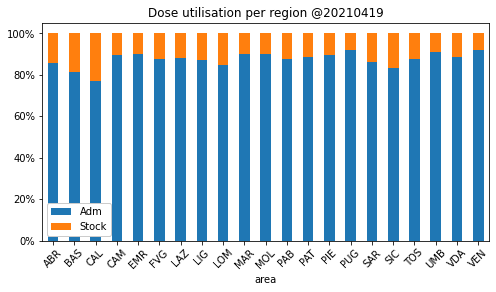

In [71]:
#PLOT VACCINE DOSES UTILISATION  BY REGION

fig, ax =plt.subplots(figsize=(8,4))


dfAdm=dfVadm.copy()
dfAdm['tot_admin']=dfAdm['prima_dose']+dfAdm['seconda_dose']
suppliers=dfAdm['fornitore'].unique()

dfDel=dfVdel.copy()
dfAdm=dfAdm.groupby(['area'])['tot_admin'].sum()
dfDel=dfDel.groupby(['area'])['numero_dosi'].sum()

df = pd.DataFrame({'Adm': dfAdm,'Del':dfDel})#, 'idx_col':dfDel.index})
df['Stock']=df['Del']-df['Adm']
df=df.drop(columns=['Del'])

# Prepare mormalized by column dataframe
norm_df = df.div(df.sum(axis=1), axis=0)

norm_df.plot(kind='bar',stacked=True,legend=False,ax=ax)

ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

ax.legend(loc='lower left',facecolor='white', framealpha=1)
ax.xaxis.set_tick_params(rotation=45)
ax.set_title('Dose utilisation per region @'+d)
plt.savefig('V'+d+'_RegionDosesUtil.png',dpi=600)
plt.show()


## Vaccine administration progress by region

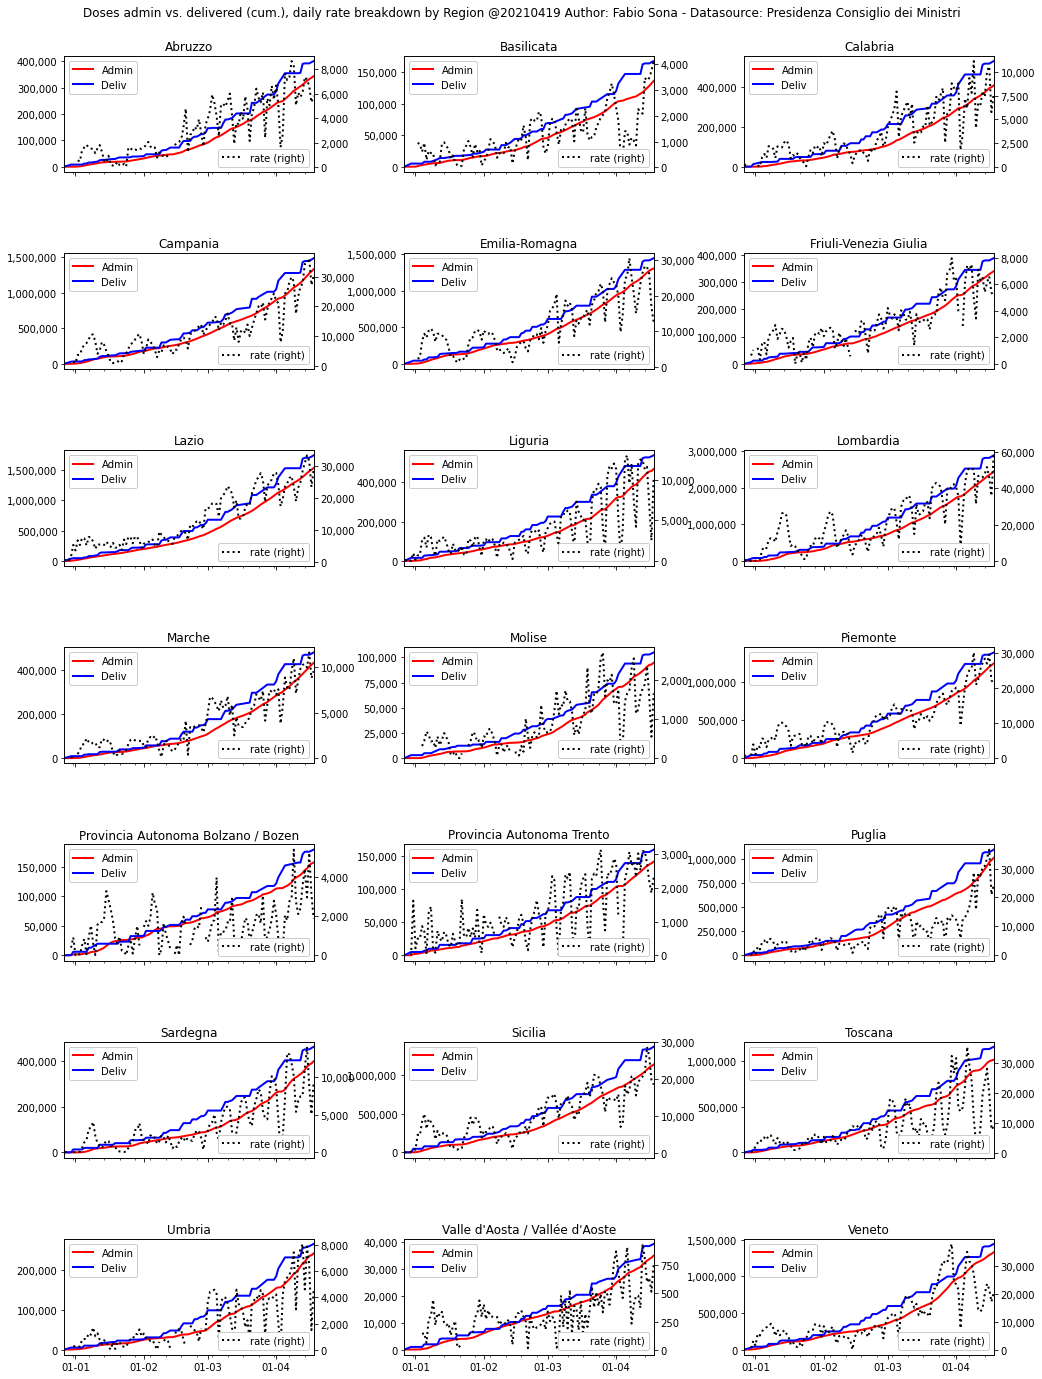

In [52]:
#Prepare data to plot administered doses vs. delivered on a daily basis
#Delivered
today=dfVadm.index[-1] #Get last date of relevant data 
d=today.strftime("%Y%m%d")
# print(d)
dfDel=dfVdel.copy()
dfDel=dfDel.sort_values('nome_area',ascending=True)
dfDel['Week_Number'] = dfDel.index.weekofyear
dfDel['Year'] = dfDel.index.year
dfDel=pd.pivot_table(dfDel, values = 'numero_dosi',index = ['data_consegna'],aggfunc=np.sum, columns = 'nome_area')#.reset_index()
dfDel=dfDel.cumsum().reset_index()
dfDel=dfDel.fillna(method='ffill')
dfDel.set_index('data_consegna',inplace=True)
dfDel["sum"] = dfDel.sum(axis=1)
#dfDel.head(100)

#Administered
dfAdm=dfVadm.copy()
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm['Week_Number'] = dfAdm.index.weekofyear
dfAdm['Year'] = dfAdm.index.year
dfAdm['tot_dosi']= dfAdm['sesso_maschile'] + dfAdm['sesso_femminile']
dfAdm=pd.pivot_table(dfAdm, values = 'tot_dosi',index = ['data_somministrazione'],aggfunc=np.sum, columns = 'nome_area')
dfDaily=dfAdm.copy()
dfDaily["sum"] = dfDaily.sum(axis=1)
dfAdm=dfAdm.cumsum().reset_index()
dfAdm=dfAdm.fillna(method='ffill')
dfAdm.set_index('data_somministrazione',inplace=True)
dfAdm["sum"] = dfAdm.sum(axis=1)


#Main loop
nrows=7 
ncols=3
fig, axes = plt.subplots(nrows, ncols,sharex=False,figsize=(15,20)) #
fig.tight_layout(pad=6)
date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
idx=0
for r in range(nrows):
  for c in range(ncols):
    # if r==0 and c==0: #First box for Nationwide data 
    #     dfAdm[dfAdm.columns[21]].plot(kind='line', linestyle="-",lw=2,color='red',grid=False,rot=0,legend=False,label='Administered',ax=axes[r,c],sharex=False)
    #     dfDel[dfDel.columns[21]].plot(kind='line', linestyle="-",lw=2,color='blue',grid=False,rot=0,legend=False,label='Delivered',ax=axes[r,c],sharex=False)
    #     ax2=axes[r,c].twinx()
    #     dfDaily[dfDaily.columns[21]].plot(kind='line', linestyle=":",lw=2,color='black',grid=False,rot=0,legend=False,label='Daily rate (right)',ax=ax2,sharex=False)       
    #     axes[r,c].set_title('Italia')
    #     # axes[r,c].set_ylabel('Nr. doses (admin, delivered)')
    #     # ax2.set_ylabel('Daily rate')
    #     ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    #     axes[r,c].set_xlabel('')
    #     axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    #     axes[r,c].xaxis.set_major_locator(mdates.MonthLocator())
    #     axes[r,c].xaxis.set_major_formatter(date_form)
    #     axes[r,c].xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
    #     axes[r,c].xaxis.set_minor_formatter(ticker.NullFormatter())   
    #     axes[r,c].legend()       
    #     ax2.legend(loc='lower right')
    #     #idx=idx+1    
    
    # elif  idx<=20 : #then plot regions individually
      
        dfAdm[dfAdm.columns[idx]].plot(kind='line', linestyle="-",lw=2,color='red',grid=False,rot=0,legend=False,label='Admin',ax=axes[r,c],sharex=False)
        dfDel[dfDel.columns[idx]].plot(kind='line', linestyle="-",lw=2,color='blue',grid=False,rot=0,legend=False,label='Deliv',ax=axes[r,c],sharex=False)
        ax2=axes[r,c].twinx()
        dfDaily[dfDaily.columns[idx]].plot(kind='line', linestyle=":",lw=2,color='black',grid=False,rot=0,legend=False,label='rate (right)',ax=ax2,sharex=False)
        
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[r,c].set_title(dfAdm.columns[idx])
        # axes[r,c].set_ylabel('Nr. doses (admin, delivered)')
        axes[r,c].set_facecolor("white")
        axes[r,c].set_xlabel('')
        axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[r,c].xaxis.set_major_locator(mdates.MonthLocator())
        axes[r,c].xaxis.set_major_formatter(date_form)
        axes[r,c].xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
        axes[r,c].xaxis.set_minor_formatter(ticker.NullFormatter())   
        axes[r,c].legend(facecolor='white', framealpha=1)
        # axes[r,c].set_visible(True)
        # axes[r,c].axes.get_xaxis().set_visible(True)
        ax2.legend(loc='lower right',facecolor='white', framealpha=1)
        # ax2.axes.get_xaxis().set_visible(True)
        idx=idx+1
#     else:
#       break
# # axes[nrows-1,ncols-1].set_visible(False)
# axes[nrows-1,ncols-2].set_visible(False)

fig.suptitle('Doses admin vs. delivered (cum.), daily rate breakdown by Region @'+d+
          ' Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',y=0.990, x=0.5)

plt.savefig('V'+d+'_RegionalDosesStatus.png',dpi=300)
plt.show()

## Vaccine administration by age group

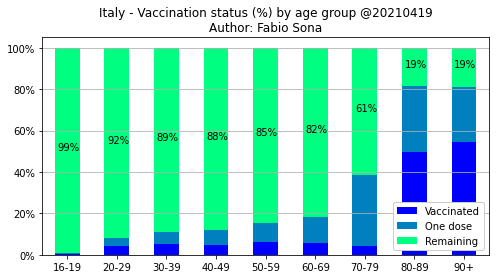

In [129]:
#Progress vaccination by group age
classagepop = {
    'agegroup' : ['0-9',	'0-9',	'10-14',	'16-19',	'20-29',	'20-29','30-39',	'30-39',	'40-49',	'40-49',	'50-59',	'50-59',	'60-69',	'60-69',	'70-79',	'70-79',	'80-89',	'80-89',	'90+',	'90+',	'90+'],
    'ageclass' : ['0-4',	'5-9','10-14',	'15-19',	'20-24',	'25-29',	'30-34',	'35-39',	'40-44',	'45-49',	'50-54',	'55-59',	'60-64',	'65-69',	'70-74',	'75-79'	,'80-84',	'85-89'	,'90-94',	'95-99',	'100+'],
    'pop' : [ 2264538,	2627956,	2835060,	2871056,	2955888,	3128494,	3282441,	3572191,	4187464	,4749765,	4876704,	4537491,	3893350,	3471014,	3324360	,2644013	,2231536,	1396624	,616360,	160379,	14804]}

dfAgePop = pd.DataFrame(classagepop) 
dfAgePop=dfAgePop.groupby(['agegroup']).sum()

dfVAge=dfVana.copy()
dfVAge=dfVAge[['fascia_anagrafica','prima_dose','seconda_dose']]
dfVAge=dfVAge.set_index('fascia_anagrafica')
dfVAge=pd.concat([dfVAge,dfAgePop],axis=1).dropna()
dfVAge['One dose']=dfVAge['prima_dose']-dfVAge['seconda_dose']
dfVAge['Remaining']=dfVAge['pop']-dfVAge['seconda_dose']-dfVAge['One dose']
dfVAge=dfVAge.rename(columns={'seconda_dose': 'Vaccinated'})
dfVAge=dfVAge.drop(['prima_dose','pop'], axis = 1)
#Normalizinf dataframe
dfVAge=dfVAge.div(dfVAge.sum(axis=1), axis=0)

fig, ax =plt.subplots(figsize=(8,4))

dfVAge.plot(kind='bar', stacked=True,colormap='winter',ax=ax).grid(axis='y')
ax.legend(facecolor='white',framealpha=1,loc='lower right')
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.xaxis.set_tick_params(rotation=0)
ax.set_title('Italy - Vaccination status (%) by age group @'+d+'\nAuthor: Fabio Sona')

[ax.text(i-0.2,1-v/2, f'{v:,.0%}',fontsize=10,color='black',rotation='horizontal') for i, v in enumerate(dfVAge['Remaining'])]
plt.savefig('V'+d+'_AgeVacc.png',dpi=600)
plt.show()

In [106]:
dfVAge

,Vaccinated,One dose,Remaining
16-19,0.002125,0.004180,0.993695
20-29,0.042961,0.040061,0.916978
30-39,0.050794,0.057458,0.891747
40-49,0.048880,0.070674,0.880445
50-59,0.061752,0.090624,0.847624
60-69,0.058158,0.124534,0.817308
70-79,0.044320,0.340824,0.614856
80-89,0.495263,0.317727,0.187009
90+,0.546586,0.262638,0.190777
